In [104]:
from load_data import * 
from analyze_data import * 
import sys
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from SWRmodule import *
sys.path.append('/home1/efeghhi/ripple_memory/')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                        MFG_labels, IFG_labels, nonHPC_MTL_labels, ENTPHC_labels, AMY_labels

############### set parameters ###############
save_data = True
start_time = -700 # recording start time relative to word onset (ms)
end_time = 2300 # recording end time relative to word onset (ms)
##############################################
catFR_dir = '/scratch/efeghhi/catFR1/ENCODING/'

region_name = '' # if empty string, loads all data

data_dict = load_data(catFR_dir, region_name=region_name, encoding_mode=1)
data_dict = remove_wrong_length_lists(data_dict)

ca1_elecs = [x for x in HPC_labels if 'ca1' in x]
data_dict_ca1 = select_region(data_dict, ca1_elecs)

In [36]:
count_num_trials(data_dict_ca1, "ca1")

Number of trials in ca1: 113628


In [64]:
# Let's first make sure we understand how np.reshape works 
num_trials = 5
num_elecs = 2
sample_data = np.ones((num_trials, num_elecs))
for idx, trial in enumerate(range(num_trials)):
    sample_data[trial]*=(idx+1)
print(sample_data)

# when we have a 2d array, reshape to -1 will ravel the array 
# so that values within a trial are placed next to each other
# (raveling along rows first)
print("Reshape with order set to C")
print(np.reshape(sample_data, -1, order='C'))
# if we use order = F, then values from the same electrode across
# trials will be placed next to each other (raveling along columns first)
# We won't use this, but it's a nice to see how it works
print("Reshape with order set to F")
print(np.reshape(sample_data, -1, order='F'))

[[1. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]
 [5. 5.]]
Reshape with order set to C
[1. 1. 2. 2. 3. 3. 4. 4. 5. 5.]
Reshape with order set to F
[1. 2. 3. 4. 5. 1. 2. 3. 4. 5.]


In [67]:
num_timesteps = 3
sample_data_3d = np.random.randint(0, 20, size=(num_trials, num_elecs, num_timesteps))
print("Example 3d data")
# Now our data has num_trials matrices, which are each of shape num_elecs x num_timesteps
# Values for each electrode are unique because the 3d is neural 
print(sample_data_3d.shape)
print(sample_data_3d)
# we want to reshape our data to be of shape (num_trial x num_elecs) x num_timesteps 
# Now rows from the same trial should be next to each other in order to maintain alignmnet 
# with the behavorial data 
sample_3d_reshaped = np.reshape(sample_data_3d, (-1, num_timesteps))
print(sample_3d_reshaped.shape)
print(sample_3d_reshaped)
# we can see see based on the printed output that data from electrodes within a trial
# are placed next to each other, instead of the same electrode from every trial being 
# in consecutive rows 
sample_3d_reshaped_F = np.reshape(sample_data_3d, (-1, num_timesteps), order='F')
print(sample_3d_reshaped_F)

Example 3d data
(5, 2, 3)
[[[ 3 14  6]
  [11 18 13]]

 [[14  3 13]
  [15 10  5]]

 [[19 14  7]
  [13  4 14]]

 [[ 0  9  4]
  [17 16 11]]

 [[14 17 10]
  [ 4  5  2]]]
(10, 3)
[[ 3 14  6]
 [11 18 13]
 [14  3 13]
 [15 10  5]
 [19 14  7]
 [13  4 14]
 [ 0  9  4]
 [17 16 11]
 [14 17 10]
 [ 4  5  2]]
[[ 3 14  6]
 [14  3 13]
 [19 14  7]
 [ 0  9  4]
 [14 17 10]
 [11 18 13]
 [15 10  5]
 [13  4 14]
 [17 16 11]
 [ 4  5  2]]


In [68]:
def dict_to_numpy(data_dict):
    
    dd_trials = {}
    for key, val in data_dict.items():
        dd_trials[key] = []
        for sess in val:
            
            # non neural data is 2D (num_trials x num_electrodes)
            # values are repeated along each row 
            if len(sess.shape) == 2:
                # reshape here will give us a 1d vector, where data for electrodes for a given trial
                # are placed next to each other 
                dd_trials[key].extend(np.reshape(sess, -1, order='F'))
            if len(sess.shape) == 3:
                # for 3d data reshape will do the same thing, meaning that electrodes from the same trial
                # are placed next to each other 
                dd_trials[key].extend(np.reshape(sess, (-1, sess.shape[-1]), order='F'))

    for key, val in dd_trials.items():
        dd_trials[key] = np.asarray(val)
        
    return dd_trials

In [100]:
dd_trials = dict_to_numpy(data_dict_ca1)

In [101]:
ripple_start = 550
ripple_end = 900
ripple_exists_idxs = np.argwhere(np.sum(dd_trials['ripple'][:, ripple_start:ripple_end],axis=1)>0)
ripple_exists = np.zeros(dd_trials['ripple'].shape[0])
ripple_exists[ripple_exists_idxs] = 1
dd_trials['ripple_exists'] = ripple_exists

In [103]:
clust = np.argwhere(dd_trials['clust']==1)
ripple = np.argwhere(dd_trials['ripple_exists']==1)
no_clust = np.argwhere(dd_trials['clust']==0)
no_ripple = np.argwhere(dd_trials['ripple_exists']==0)
clust_ripple = np.intersect1d(clust, ripple)
no_clust_ripple = np.intersect1d(no_clust, ripple)
clust_no_ripple = np.intersect1d(clust, no_ripple)
no_clust_no_ripple = np.intersect1d(no_clust, no_ripple)

/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
dd_trials['theta_phase'].shape

(113628, 1500)

In [73]:
dd_trials = create_semantic_clustered_array(dd_trials)

In [17]:
a = np.zeros(10)
a[0] = 1
np.argwhere(a==1)[0][0]

0

In [22]:
for i, start_time in enumerate(s):
    print(start_time.shape)
    break

(1500,)


In [23]:
theta_phase_ripple_start = []
theta_phase = dd_trials['theta_phase']
for i, start_time in enumerate(s):
    ripple_start = np.argwhere(start_time==1)
    if ripple_start.shape[0] == 1:
        theta_phase_ripple_start.append(theta_phase[i, ripple_start[0][0]])
    

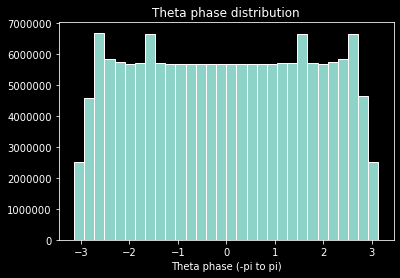

In [34]:
plt.style.use('dark_background')
plt.title("Theta phase distribution")
plt.xlabel("Theta phase (-pi to pi)")
plt.hist(np.ravel(theta_phase), bins=np.linspace(-np.pi, np.pi, num=31), edgecolor='white')
plt.show()

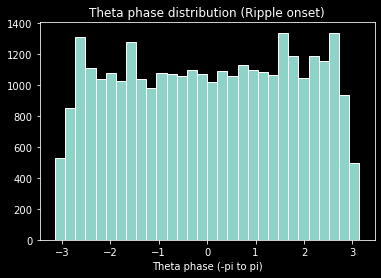

In [33]:
plt.style.use('dark_background')
plt.title("Theta phase distribution (Ripple onset)")
plt.xlabel("Theta phase (-pi to pi)")
plt.hist(theta_phase_ripple_start, bins=np.linspace(-np.pi, np.pi, num=31), edgecolor='white')
plt.show()

In [74]:
HFA_start = 55
HFA_end = 90
regression_mat = pd.DataFrame({'HFA':np.mean(dd_trials['HFA'][:, HFA_start:HFA_end] ,axis=1), 
                               'ripple':ripple_exists, 'clust':dd_trials['clust'], 
                               'sess': dd_trials['sess'], 'subj':dd_trials['subj']})

In [90]:
import statsmodels.formula.api as smf

vc = {'sess':'0+sess'}
model = smf.mixedlm("clust ~ HFA + HFA:ripple", regression_mat, groups="subj", vc_formula=vc, 
                                re_formula='HFA + HFA:ripple')
model = model.fit(reml=True, method='nm',maxiter=2000)
print(model)

/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [94]:
print(model.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   clust       
No. Observations:    113628    Method:               REML        
No. Groups:          101       Scale:                0.5177      
Min. group size:     84        Likelihood:           -124220.9861
Max. group size:     10500     Converged:            Yes         
Mean group size:     1125.0                                      
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept             -0.604    0.022 -27.344 0.000 -0.648 -0.561
HFA                    0.015    0.002   6.552 0.000  0.011  0.020
HFA:ripple            -0.013    0.003  -3.899 0.000 -0.019 -0.006
subj Var               0.040    0.009                            
subj x HFA Cov         0.001    0.001                            
HFA Var                0

In [75]:
df_filtered = regression_mat[regression_mat['clust'] != -1]

In [76]:
# Group by 'ripple' and 'clust', calculate the mean of 'HFA', and count the number of rows in each group
result = df_filtered.groupby(['ripple', 'clust'])['HFA'].agg(['mean', 'count']).reset_index()
result.columns = ['ripple', 'clust', 'mean_HFA', 'count_rows']
result

,ripple,clust,mean_HFA,count_rows
0,0.0,0.0,-0.053217,12946
1,0.0,1.0,0.069108,15189
2,1.0,0.0,1.439726,3261
3,1.0,1.0,1.559277,4455


In [77]:
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.head()

,HFA,ripple,clust,sess,subj
0,-1.728180,0.0,0.0,R1015J-0,R1015J
1,-0.718011,0.0,0.0,R1015J-0,R1015J
2,-0.558179,0.0,0.0,R1015J-0,R1015J
3,-0.005076,0.0,0.0,R1015J-0,R1015J
4,-0.028606,0.0,0.0,R1015J-0,R1015J


In [79]:
def triangleSmooth(data,smoothing_triangle): # smooth data with triangle filter using padded edges
    
    # problem with this smoothing is when there's a point on the edge it gives too much weight to 
    # first 2 points (3rd is okay). E.g. for a 1 on the edge of all 0s it gives 0.66, 0.33, 0.11
    # while for a 1 in the 2nd position of all 0s it gives 0.22, 0.33, 0.22, 0.11 (as you'd want)
    # so make sure you don't use data in first 2 or last 2 positions since that 0.66/0.33 is overweighted
    
    factor = smoothing_triangle-3 # factor is how many points from middle does triangle go?
    # this all just gets the triangle for given smoothing_triangle length
    f = np.zeros((1+2*factor))
    for i in range(factor):
        f[i] = i+1
        f[-i-1] = i+1
    f[factor] = factor + 1
    triangle_filter = f / np.sum(f)

    padded = np.pad(data, factor, mode='edge') # pads same value either side
    smoothed_data = np.convolve(padded, triangle_filter, mode='valid')
    return smoothed_data

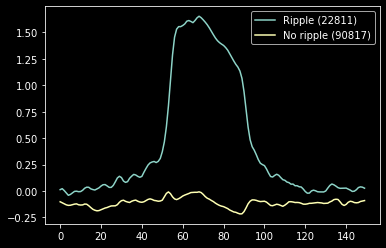

In [80]:
HFA_ripple = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][ripple]),axis=0), smoothing_triangle=5)
HFA_no_ripple = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][no_ripple]),axis=0), smoothing_triangle=5)
plt.style.use('dark_background')
plt.plot(HFA_ripple, label=f"Ripple ({ripple.shape[0]})")
plt.plot(HFA_no_ripple, label=f"No ripple ({no_ripple.shape[0]})")
plt.legend()
plt.show()

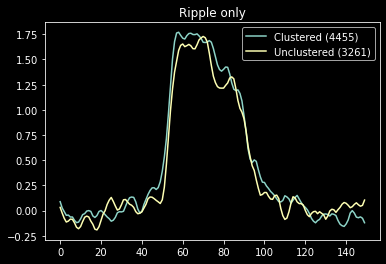

In [95]:
HFA_clust = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][clust_ripple]),axis=0), smoothing_triangle=5)
HFA_no_clust = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][no_clust_ripple]),axis=0), smoothing_triangle=5)
plt.style.use('dark_background')
plt.plot(HFA_clust, label=f"Clustered ({clust_ripple.shape[0]})")
plt.plot(HFA_no_clust, label=f"Unclustered ({no_clust_ripple.shape[0]})")
plt.legend()
plt.title("Ripple only")
plt.show()

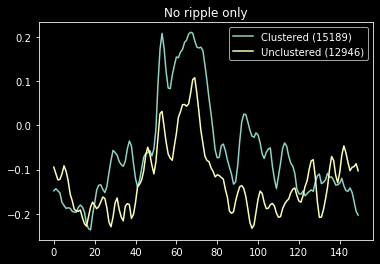

In [99]:
HFA_clust = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][clust_no_ripple]),axis=0), smoothing_triangle=5)
HFA_no_clust = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][no_clust_no_ripple]),axis=0), smoothing_triangle=5)
plt.style.use('dark_background')
plt.plot(HFA_clust, label=f"Clustered ({clust_no_ripple.shape[0]})")
plt.plot(HFA_no_clust, label=f"Unclustered ({no_clust_no_ripple.shape[0]})")
plt.title("No ripple only")
plt.legend()
plt.show()

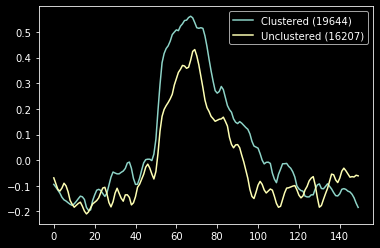

In [97]:
HFA_clust = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][clust]),axis=0), smoothing_triangle=5)
HFA_no_clust = triangleSmooth(np.mean(np.squeeze(dd_trials['HFA'][no_clust]),axis=0), smoothing_triangle=5)
plt.style.use('dark_background')
plt.plot(HFA_clust, label=f"Clustered ({clust.shape[0]})")
plt.plot(HFA_no_clust, label=f"Unclustered ({no_clust.shape[0]})")
plt.legend()
plt.show()